In [1]:
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated, List
import operator
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from IPython.display import display, Image, Markdown
from langchain_core.messages import HumanMessage, SystemMessage
from pprint import pprint
from langfuse.callback import CallbackHandler

llm = ChatOpenAI(model = "gpt-4o-mini", temperature = 0.2)
langfuse_handler = CallbackHandler()

## Create Evaluator

In [2]:
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(description="Decide if the joke is funny or not")
    feedback: str = Field(description="If the joke is not funny, provide feedback on how to improve it")

evaluator = llm.with_structured_output(Feedback)

class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

## Create Generator

In [6]:
def llm_call_generator(state: State):
    '''LLM generate a joke'''

    if state.get("feedback"):
        msg = llm.invoke(f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}. ")
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}. ")

    return {"joke": msg.content}

def llm_call_evaluator(state: State):
    '''LLM evaluate the joke'''
    grade = evaluator.invoke(f"Grade the joke {state["joke"]}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

def route_joke(state:State):
    '''Route the joke to the appropriate state'''
    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


## Create the Graph

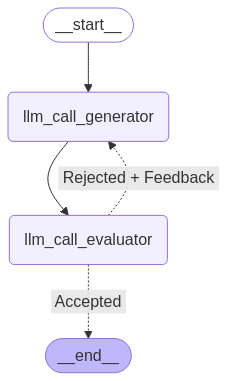

In [7]:
builder = StateGraph(State)

builder.add_node("llm_call_generator", llm_call_generator)
builder.add_node("llm_call_evaluator", llm_call_evaluator)

builder.add_edge(START, "llm_call_generator")
builder.add_edge("llm_call_generator", "llm_call_evaluator")
builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator"
    }
)

workflow = builder.compile()

display(Image(workflow.get_graph().draw_mermaid_png()))


In [9]:
state = workflow.invoke({"topic": "Amazon"}, config={"callbacks": [langfuse_handler]})
pprint(state)

{'feedback': '',
 'funny_or_not': 'funny',
 'joke': 'Why did the customer break up with their partner after ordering from '
         'Amazon? \n'
         '\n'
         'Because they realized they could get same-day delivery on everything '
         'they needed—except for emotional support!',
 'topic': 'Amazon'}
